# Correlation between epidemic distance and temporal graph distance

In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
import seaborn as sns
from tqdm import tqdm
import itertools
from scipy.spatial.distance import jensenshannon


import sys
sys.path += ['package']

from MatrixDistance import *
from GraphCreation import *
from Utilities import *

import warnings
warnings.filterwarnings("ignore")

### Function definitions

In [27]:
def get_time_sequences(df_SP):
    # we build df_SP so that it contains (i,j,t, day)
    df_SP = df_SP[['t','i','j','day']]
    all_pairs = df_SP.groupby(['i', 'j', 'day']).size().reset_index()[['i', 'j', 'day']].values
    df_SP.set_index(['i', 'j', 'day'], inplace = True) # <-- so this is a time series of t, where i, j and day are the indeces

    timeF = []

    # a pair is in the form (i, j, day) and timeF stores all the interactions between i and j on day t
    for x, pair in enumerate(all_pairs):
        print(str(np.round((x+1)/len(all_pairs)*100,2)) + ' %', end = '\r')
        i, j, day = pair
        timeF.append(df_SP.loc[i, j, day].t.values) 
        
    # we then construct time FR that for each (i,j,t) stores the edge time-line, centered to 00:00 of the corresponding day 
    timeFR = [[] for x in range(len(timeF))]

    for a, T in enumerate(timeF):
        print(str(np.round((a+1)/len(all_pairs)*100,2)) + ' %', end = '\r')
        for t in T:
            if (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-01 08:00:00')).days == 1:
                tt = (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-02 08:00:00')).total_seconds()
                
            else:
                tt = (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-01 08:00:00')).total_seconds()
                
            timeFR[a].append(tt)
    return timeFR


In [28]:
def temporal_ER(time_sequence, k_mean, n, time_aggregation):
    """
    It creates a temporal Erdos-Renyi model 

    Input:
        * time_sequence (list): list of timesequences (each timesequence is a list of timestamps)
        * k_mean (float): mean degree of the graph
        * n (int): number of nodes
        * time_aggragation (float): the desired time aggregation (in minutes)
    Output:
        * dft (DataFrame): temporal network in the form (i,j,t,τ) (τ edge weight)
    """
    

    symmetric = True
    make_connected = True

    C = np.ones((1,1))*k_mean

    
    ℓ = np.zeros(n).astype(int)
    θ = np.ones(n)
    args = (C, k_mean, ℓ, θ, symmetric, make_connected)

    dft = DCSBM(args)
    dft = MakeTemporal(dft, time_sequence, time_aggregation)
    return dft




### Time sequences

In [29]:
# HIGH SCHOOL 2013 - day 1 
path = 'school_data/data/High-School_data_2013.csv'
df_SP = pd.read_csv(path, header = None, sep = ' ', names = ['t', 'i', 'j','c_i','c_j'])
df_SP['day'] = pd.to_datetime(df_SP.t, unit = 's')
df_SP['day'] = df_SP.day.dt.day

high_school_day1 = get_time_sequences(df_SP[df_SP.day == 2])

# HIGH SCHOOL 2013 - day 2
#high_school_day2 = get_time_sequences(df_SP[df_SP.day == 3])

# PRIMARY SCHOOL - day 1 
#path = 'school_data/data/tij_pres_primaryschool.csv'
#df_SP = pd.read_csv(path, header = None, sep = '\t', names = ['t', 'i', 'j','c_i','c_j'])
#df_SP['day'] = pd.to_datetime(df_SP.t, unit = 's')
#df_SP['day'] = df_SP.day.dt.day

#primary_school = get_time_sequences(df_SP[df_SP.day == 1])

# CONFERENCE...
#path = 
#df_SP = pd.read_csv(path, header = None, sep = ' ', names = ['t', 'i', 'j','c_i','c_j'])
#df_SP['day'] = pd.to_datetime(df_SP.t, unit = 's')
#df_SP['day'] = df_SP.day.dt.day

#conference = get_time_sequences(df_SP[df_SP.day == 1])


KeyboardInterrupt: 

## ER

In [ ]:
n = 100
n_graphs = 10
time_aggregation = 1


graphs = {}
for k in np.logspace(-1, 1, 20):
    graphs[k] = []
    for i in range(n_graphs):
        graphs[k].append(temporal_ER(high_school_day1, k, n,time_aggregation))

In [ ]:
n_sim = 100
beta = 0.5
mu = 0.02
f = 0.1

sir_output = {}
for k,graph_set in tqdm(graphs.items()):
    sir_output[k] = []
    for graph in graph_set:
        output = []
        for sim in range(n_sim):
            m = SIR_model(graph)
            states = m.simulate(beta, mu, f)
            R = len(states[-1]['R'])
            n = len(states[-1]['R'])+len(states[-1]['S'])+len(states[-1]['I'])
            output.append(R/n)
        sir_output[k].append(output)

100%|██████████| 20/20 [20:16<00:00, 60.85s/it]


In [ ]:
combinations = list(itertools.combinations(graphs.keys(),2))

In [33]:
distance = {}
distance_epi = {}
for x,y in tqdm(combinations):
    distance[(x,y)] = []
    distance_epi[(x,y)] = []

    for i in range(n_graphs):
        
        distance[(x,y)].append(DynamicGraphDistance(graphs[x][i], graphs[y][i]))
        distance_epi[(x,y)].append(jensenshannon(sir_output[x][i],sir_output[y][i]))
    

100%|██████████| 190/190 [1:11:25<00:00, 22.55s/it] 


In [48]:
correlations = {}
for k,v in distance.items():
    correlations[k] = np.corrcoef(v,distance_epi[k])[0,1]


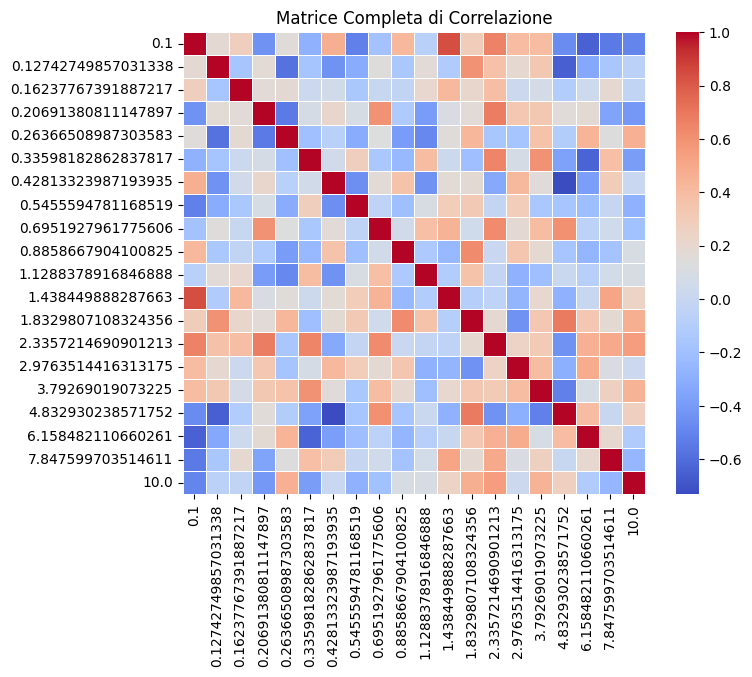

In [64]:
nodes = sorted(set(itertools.chain(*correlations.keys())))

# 🔹 Creiamo la matrice vuota
correlations_df = pd.DataFrame(index=nodes, columns=nodes, dtype=float)

# 🔹 Riempire la matrice con i valori del dizionario
for (i, j), value in correlations.items():
    correlations_df.loc[i, j] = value
    correlations_df.loc[j, i] = value  # Aggiungere il valore inverso

# 🔹 Impostiamo la diagonale a 1 (correlazione perfetta con se stessi)
for node in nodes:
    correlations_df.loc[node, node] = 1.0

# 🔹 Convertiamo tutto a numerico (evitiamo NaN)
correlations_df = correlations_df.astype(float)

# 🔹 Creiamo la heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(correlations_df, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)


plt.title("Matrice Completa di Correlazione")
plt.show()

In [71]:
for i in range(0,20, 2):
    print(i)

0
2
4
6
8
10
12
14
16
18


In [ ]:
#m = SIR_model(graphs[0])
#states = m.simulate(0.5, 0.02, 0.1)
#plt.plot(np.sort(graphs[0].t.unique())[:min(len(graphs[0].t.unique()),len(states))], [len(x['S']) for x in states][:min(len(graphs[0].t.unique()),len(states))], label='s')
#plt.plot(np.sort(graphs[0].t.unique())[:min(len(graphs[0].t.unique()),len(states))], [len(x['I']) for x in states][:min(len(graphs[0].t.unique()),len(states))], label='i')
#plt.plot(np.sort(graphs[0].t.unique())[:min(len(graphs[0].t.unique()),len(states))], [len(x['R']) for x in states][:min(len(graphs[0].t.unique()),len(states))], label='r')
#plt.legend()
#plt.show()